# Skoda Auto - rides

This notebook uses Skoda rides data. The data covers movement of vehicles for work-related trips for period March to September 2019.

TODO:
- nahrat vsechny trips/postupne zprocesovat - PROBLEM
- varianta 1: points to trajectry v  postgis + detectstops (A.Graser)
- varianta 2: points, adapted detectstops to add column trip, trajectory pomoci group by (carid,trip)
- vypsat statistiky (sql po inicializaci/pandas) - jake vsechny?
- poresit carid to be categorized not continuous int - DONE zmenil jsem typ v PSQL z text na integer
- dopocitat speed (movingpandas function) - DONE
- origins/destinations do postgis db 
- statistiky pro dny/podle hodin - histogram?
- clustering origins/destinations v postgisu

 

In [1]:
%matplotlib inline

In [2]:
import urllib
import os
import pandas as pd
import contextily as ctx
from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import psycopg2
from debug import *

import sys
sys.path.append("..")
import movingpandas as mp

import warnings
warnings.simplefilter("ignore")

## Area of interest: Europe

Using zoom level 8, this will download 196 tiles
CPU times: user 1.51 s, sys: 207 ms, total: 1.72 s
Wall time: 15.7 s


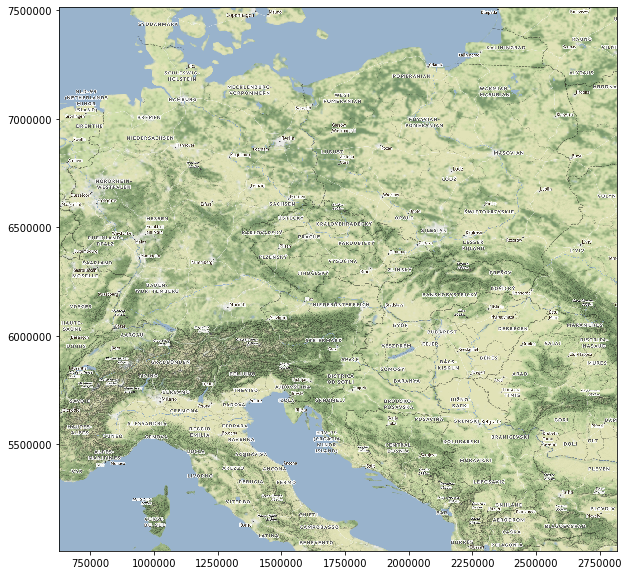

In [3]:
ZOOM_LEVEL = 8
w, s, e, n = 6, 43, 24, 54.5

# check number of tiles that will be downloaded
ctx.howmany(w, s, e, n, ZOOM_LEVEL, ll=True)

# download tiles
%time img, ext = ctx.bounds2img(w, s, e, n, ZOOM_LEVEL-1, ll=True)

# plot map 
plt.rcParams['figure.figsize'] = (10,10)
plt.imshow(img, extent=ext, aspect='auto')

## Loading data from PostGIS db


In [4]:
con = psycopg2.connect(database="skoda-postgres", user="root", password="sumpr0ject",
    host="localhost", port=35432)
sql = "SELECT * FROM rides LIMIT 100000;"
# sql = "SELECT * FROM rides WHERE carid IN ('524305','536208') AND datetime BETWEEN '2019-05-10' AND '2019-05-11';"

df = GeoDataFrame.from_postgis(sql, con, geom_col='geometry' )

Let's see what the data looks like:

In [5]:
wgs84 = df.crs
df.head()
# df.dtypes

,carid,datetime,geometry
0,524305,2019-03-01 11:44:06,POINT (14.92328 50.42229)
1,524305,2019-03-01 11:44:16,POINT (14.92506 50.42212)
2,524305,2019-03-01 11:44:27,POINT (14.92652 50.42167)
3,524305,2019-03-01 11:44:33,POINT (14.92675 50.42142)
4,524305,2019-03-01 11:44:43,POINT (14.92742 50.42102)


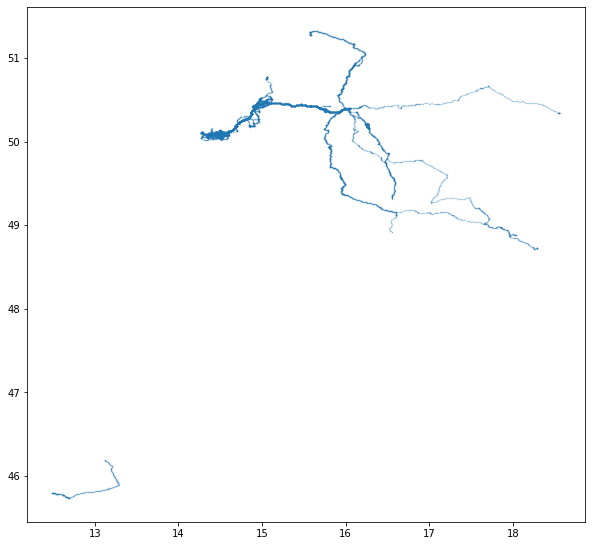

In [6]:
df.plot(markersize=0.1, alpha=0.2)

To convert the DataFrame to Trajectories we need to create a temporal index:

In [68]:
df['t'] = pd.to_datetime(df['datetime'], format='%d/%m/%Y %H:%M:%S')
df = df.set_index('t')
#df['carid']=df['carid'].astype(int)
type(df['carid'])


numpy.int64

If we look at the data distributions, we can see that there are a lot of records with speed over ground (SOG) values of zero in this dataframe:

2019-03-01 05:47:27
2019-09-13 15:07:21


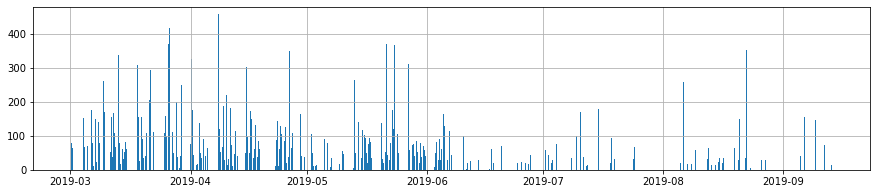

In [8]:
start_day = min(df['datetime'])
end_day = max(df['datetime'])
print(start_day)
print(end_day)
df['datetime'].hist(bins=4000, figsize=(15,3))

Let's get rid of these rows with zero SOG:

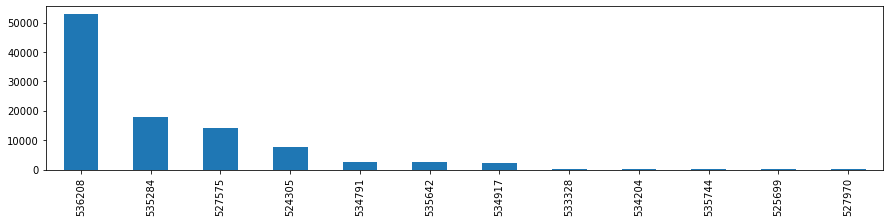

In [9]:
df['carid'].value_counts().plot(kind='bar', figsize=(15,3))


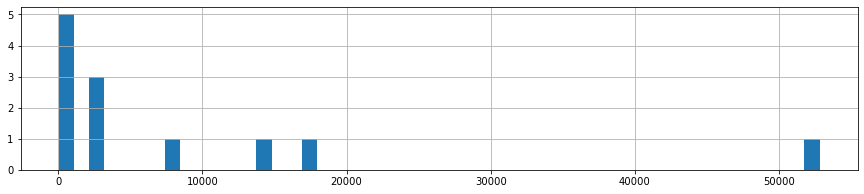

In [10]:


df['carid'].value_counts().hist(bins=50,figsize=(15,3))

Finally, let's create trajectories:

In [11]:
MIN_LENGTH = 100 # meters

t_start = datetime.now()


trajectories = []
generalized_trajs = []
            
for key, values in df.groupby(['carid']):
    if len(values) < 2:
        continue
    trajectory = mp.Trajectory(key, values)
    if trajectory.get_length() < MIN_LENGTH:
        continue
#     print(trajectory)
    trajectories.append(trajectory)
    generalized_trajs.append(trajectory.generalize(mode='douglas-peucker', tolerance=0.001)) #(mode='min-time-delta', tolerance=timedelta(minutes=5))

print("Finished creating {} trajectories in {}".format(len(trajectories),datetime.now() - t_start))

Finished creating 12 trajectories in 0:00:25.161827


## Plotting trajectories

Let's give the most common ship types distinct colors. The remaining ones will be just grey:

In [13]:
def plot_vessel_trajectories(trajs):
    shiptype_to_color = {
        'Passenger': 'blue', 
        'HSC': 'green', 
        'Tanker': 'red',
        'Cargo': 'orange'}
    default_color = 'blue'

    ax = None
    for traj in trajs:
#         ship_type = traj.df['ShipType'].iloc[0]
        ship_type = None

        try:
            ship_color = shiptype_to_color[ship_type]
        except KeyError:
            ship_color = default_color

        if ax is None:
            ax = traj.plot(linewidth=1, capstyle='round', column='Name', legend=True, figsize=(12,9), color=ship_color)
        else:
            traj.plot(ax=ax, linewidth=1, capstyle='round', column='Name', legend=True, figsize=(12,9), color=ship_color) 

CPU times: user 11.7 s, sys: 199 ms, total: 11.9 s
Wall time: 11 s


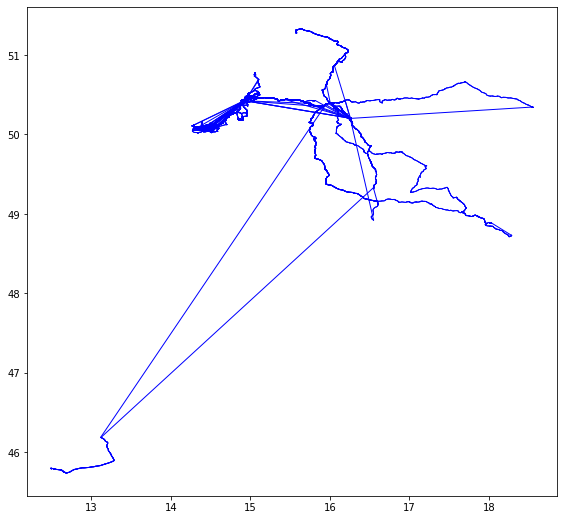

In [14]:
%%time
plot_vessel_trajectories(trajectories)

CPU times: user 2.69 s, sys: 122 ms, total: 2.82 s
Wall time: 2.07 s


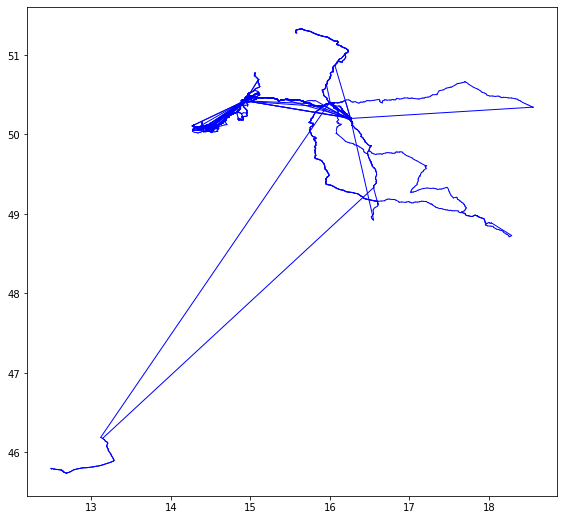

In [15]:
%%time
plot_vessel_trajectories(generalized_trajs)

## Visualizing trajectory properties

We can also plot individual trajectories to better visualize their properties, such as the changes in NavStatus:

In [16]:
my_traj = trajectories[0]
my_traj.df.head()

,carid,datetime,geometry
t,,,
2019-03-01 11:44:06,524305,2019-03-01 11:44:06,POINT (14.92328 50.42229)
2019-03-01 11:44:16,524305,2019-03-01 11:44:16,POINT (14.92506 50.42212)
2019-03-01 11:44:27,524305,2019-03-01 11:44:27,POINT (14.92652 50.42167)
2019-03-01 11:44:33,524305,2019-03-01 11:44:33,POINT (14.92675 50.42142)
2019-03-01 11:44:43,524305,2019-03-01 11:44:43,POINT (14.92742 50.42102)


In [37]:
my_traj.df.tail()

,carid,datetime,geometry,speed
t,,,,
2019-09-13 10:31:11,524305,2019-09-13 10:31:11,POINT (14.91926 50.42253),9.183208
2019-09-13 10:31:16,524305,2019-09-13 10:31:16,POINT (14.91941 50.42256),2.248477
2019-09-13 10:31:36,524305,2019-09-13 10:31:36,POINT (14.91948 50.42281),1.386942
2019-09-13 10:31:44,524305,2019-09-13 10:31:44,POINT (14.91976 50.42280),2.465757
2019-09-13 10:32:45,524305,2019-09-13 10:32:45,POINT (14.92003 50.42279),0.324645


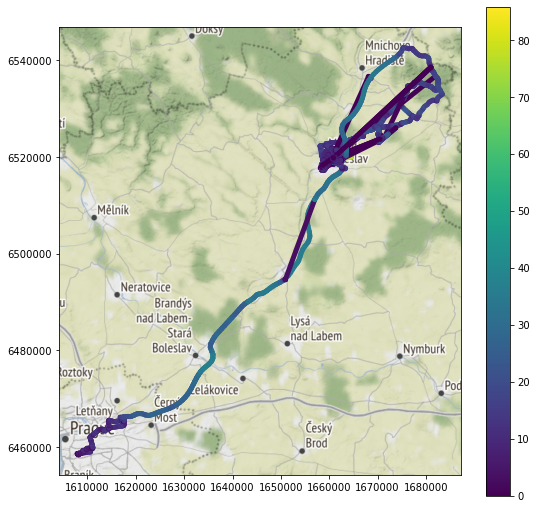

In [38]:
ZOOM_LEVEL = 10  # don't increase to ZOOM_LEVEL >= 15 because this causes a tile not found 404 error
my_traj.plot(with_basemap=True, linewidth=5.0, capstyle='round', column='speed', legend=True, 
                          figsize=(9,9), url=ctx.sources.ST_TERRAIN, zoom=ZOOM_LEVEL) 

Note: When plotting with basemap, you may run into missing map tiles. For Stamen, you can check map tile availability for a region and zoom level at http://maps.stamen.com/#terrain/15/57.6714/11.8120

Available tile sources are listed in https://github.com/darribas/contextily/blob/master/contextily/tile_providers.py, e.g.

```
ST_TONER = 'http://tile.stamen.com/toner/{z}/{x}/{y}.png'
ST_TONER_HYBRID = 'http://tile.stamen.com/toner-hybrid/{z}/{x}/{y}.png'
ST_TONER_LABELS = 'http://tile.stamen.com/toner-labels/{z}/{x}/{y}.png'
ST_TONER_LINES = 'http://tile.stamen.com/toner-lines/{z}/{x}/{y}.png'
ST_TONER_BACKGROUND = 'http://tile.stamen.com/toner-background/{z}/{x}/{y}.png'
ST_TONER_LITE = 'http://tile.stamen.com/toner-lite/{z}/{x}/{y}.png'

ST_TERRAIN = 'http://tile.stamen.com/terrain/{z}/{x}/{y}.png'
ST_TERRAIN_LABELS = 'http://tile.stamen.com/terrain-labels/{z}/{x}/{y}.png'
ST_TERRAIN_LINES = 'http://tile.stamen.com/terrain-lines/{z}/{x}/{y}.png'
ST_TERRAIN_BACKGROUND = 'http://tile.stamen.com/terrain-background/{z}/{x}/{y}.png'

ST_WATERCOLOR = 'http://tile.stamen.com/watercolor/{z}/{x}/{y}.png'
```

More on plotting GeoPandas GeoDataframes: http://geopandas.org/gallery/plotting_basemap_background.html

## Finding ships passing under Älvsborgsbron bridge - USELESS
We can find ships passing under the bridge based on trajectory intersections with the bridge area.

In [39]:
area_of_interest = Polygon([(
              14.924583435058592,
              50.43126756156562),
            (
              14.918060302734375,
              50.420495471498114
            ),
            (
              14.938144683837889,
              50.413330948495485
            ),
            (
              14.941835403442383,
              50.42558107823979
            ),
            (
              14.924583435058592,
              50.43126756156562
            )])

In [ ]:
intersections = []
for traj in trajectories:
    if traj.to_linestring().intersects(area_of_interest):
        intersections.append(traj)
print("Found {} intersections".format(len(intersections)))

In [ ]:
bridge_traj = intersections[3]
bridge_traj.plot(with_basemap=True, linewidth=5, capstyle='round', column='carid', legend=True,
                          figsize=(9,9), url=ctx.sources.ST_TERRAIN, zoom=ZOOM_LEVEL) 

In [ ]:
bridge_traj.df.head()

## Identifying trip origins and destinations

Since AIS records with a speed over ground (SOG) value of zero have been removed from the dataset, we can use the `split_by_observation_gap()` function to split the continuous observations into individual trips:

In [55]:
trips = []
for traj in trajectories:
    for x in traj.split_by_observation_gap(timedelta(minutes=5)):
        if x.get_length() > MIN_LENGTH:
            trips.append(x)
print("Extracted {} individual trips from {} continuous vessel tracks".format(len(trips), len(trajectories)))

Extracted 2238 individual trips from 12 continuous vessel tracks


*Note: Splitting continous observations by observation gap is a straightforward way to extract individual trips. More sophisticated approaches require stop detection methods that do not require extended periods of time where the speed is at zero. MovingPandas so far does not implement such stop detection functions.*

Let's plot the resulting trips!

CPU times: user 11min 15s, sys: 24.9 s, total: 11min 40s
Wall time: 8min 42s


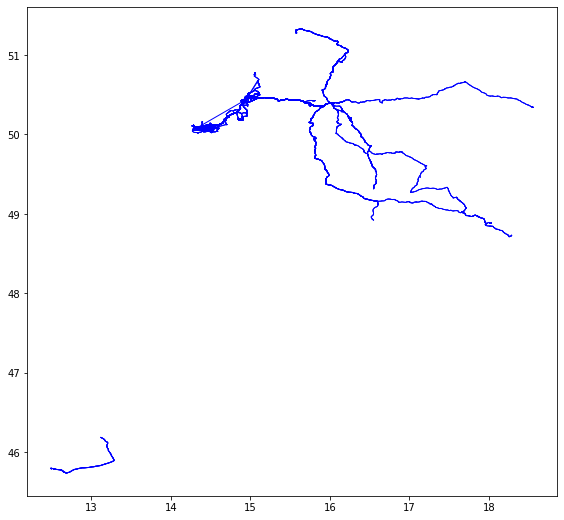

In [56]:
%%time
plot_vessel_trajectories(trips)

Compared to plotting the original continuous observations, this visualization is much cleaner because there are no artifacts at the border of the area of interest. 

Next, let's get the trip origins:

In [58]:
origins = []
for trip in trips:
    origins.append({'geometry': trip.get_start_location(), 'id': trip.id, 
                    'carid': trip.df.head(1)['carid'][0],'datetime': trip.df.head(1)['datetime'][0]})
origins = GeoDataFrame(pd.DataFrame(origins), crs=wgs84)

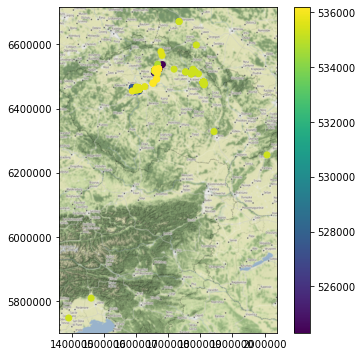

In [59]:
ax = origins.to_crs(epsg=3857).plot(column='carid', legend=True, figsize=(6,6))
ctx.add_basemap(ax, url=ctx.sources.ST_TERRAIN, zoom=ZOOM_LEVEL)

In our data sample, trip origins can be:
- When a ship departs its anchoring location and the speed changes from 0 to >0
- When a ship trajectory first enters the observation area

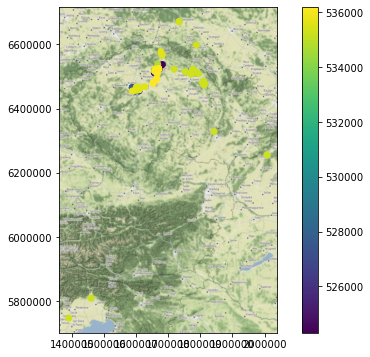

In [60]:
ax = origins.to_crs(epsg=3857).plot(column='carid', legend=True, figsize=(9,6))
ctx.add_basemap(ax, url=ctx.sources.ST_TERRAIN, zoom=ZOOM_LEVEL)

## Finding vehicles that depart from Karlovo namesti CTU

In [ ]:
# karlovo namesti CVUT areal
area_of_interest = Polygon([(
              14.416846632957458,
              50.076604219275936
),
            (
              14.416674971580505,
              50.076490610564875
            ),
            (
              14.416835904121399,
              50.07602584485287
            ),
            (
              14.418354034423826,
              50.07610502747774
            ),
            (
              14.41826283931732,
              50.07671094236533
            ),
            (
              14.416846632957458,
              50.076604219275936
            )])

We can identify vessels that start their trip within a given area of interest by intersecting trip starting locations with our area of interest:

In [ ]:
departures = []
for traj in trips:
    if traj.get_start_location().intersects(area_of_interest):
        departures.append(traj)
print("Found {} departures".format(len(departures)))

In [ ]:
departures[1].plot(with_basemap=True, linewidth=5, capstyle='round', column='carid', legend=True,
                          figsize=(9,9), url=ctx.sources.ST_TERRAIN, zoom=ZOOM_LEVEL) 

Let's see what kind of ships depart from here:

In [ ]:
for traj in departures:
    print("{} Car '{}' departed at {}".format(traj.df['ShipType'].iloc[0], traj.df['Name'].iloc[0], traj.get_start_time()))

Of course, the same works for arrivals:

In [ ]:
arrivals = []
for traj in trips:
    if traj.get_end_location().intersects(area_of_interest):
        arrivals.append(traj)
print("Found {} arrivals".format(len(arrivals)))

for traj in arrivals:
    print("{} vessel '{}' arrived at {}".format(traj.df['carid'].iloc[0], traj.df['carid'].iloc[0], traj.get_end_time()))

## Additional statistics

### Speed

In [61]:
#Avg speed in km/h
avgSpeed = []
for trajectory in trips:
    trajectory.add_speed(overwrite=True)
    avgSpeed.append((sum(trajectory.df.speed)/trajectory.df.speed.size)*3.6)

In [54]:
trajectories[3].get_length()/1000

1.6369995587021093

In [65]:
type(trajectories[0])

movingpandas.trajectory.Trajectory

In [46]:
print("Trajectories of " +  str(len(df.carid.unique())) + " unique users")
print()


array([524305, 525699, 527575, 527970, 533328, 534204, 534791, 534917,
       535284, 535642, 535744, 536208])